# Import Packages and Data

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import scipy.stats as stats
import pylab  

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_pickle('nyc_taxi_prepped.pickle')

In [ ]:
# recode impossible values

# change 0 passenger count to 1 which is the mode of passenger count
df['passenger_count'].loc[df['passenger_count']==0] = 1


# Preparing General DataFrame for Fare and Tip Prediction

In [74]:
# Create categorical variables for continuous variables
# convert passenger count to passenger range
df['passenger_range']=pd.Series(pd.cut(df['passenger_count'], [0, 2, 5,9], 
                                        labels=['1-2','3-5','5+'], retbins=False, right=True))

# convert distance to distance range
df['distance_range']=pd.Series(pd.cut(df['trip_distance'], [0, 1.32, 2.47,4.5,50], 
                                        labels=['Q1','Q2','Q3','Q4'], retbins=False, right=False))

In [75]:
# convert time to time range
df['time_range']=pd.Series(pd.cut(df['trip_duration_hour'],[0,0.1, 0.16,0.25,2.98],labels=['Q1','Q2','Q3','Q4'],
                                    include_lowest=True, right=False,retbins=False))


In [ ]:
df.describe()

In [78]:
# conver pick up hour and drop off hour to 2-hour intervals
labels=['0-1','2-3','4-5','6-7','8-9','10-11','12-13','14-15','16-17','18-19','20-21','22-23']
df['pickuphour_range']=pd.Series(pd.cut(df['pickup_hour'], list(np.arange(0,25,2)), labels=labels,right=False))
df['dropoffhour_range']=pd.Series(pd.cut(df['dropoff_hour'], list(np.arange(0,25,2)), labels=labels,right=False))
df['speed_range']=pd.Series(pd.cut(df['trip_speed'],[0,8.45,11.34,15.16,240],labels=['Q1','Q2','Q3','Q4'],
                                    include_lowest=True, right=False,retbins=False))

In [ ]:
pd.set_option("display.max_columns", None)

df.describe()

df = pd.to_pickle('nyc_taxi_analytical_dataset.pickle')

# Preparing DataFrame Version for Tip Prediction

In [79]:
#Select data for prediction model
# 1) because tip amount is missing for cash payment, analysis is limited to trips with credit card payments 
tip_filter1 = (df['payment_type']=='CRD')

# 2) trip with negotiated fare and 0 tip were excluded, becuase tip was likely included in the negotiated fare
tip_filter2 = (df['rate_code']!=5) | (df['tip_amount']!=0)


In [80]:
# subset data
df_tip = df[tip_filter1 & tip_filter2]

# display how many were included
print('A total of',len(df) - len(df_tip),'records were non-credit card transactions, and',len(df_tip),'were included in prediction analysis')

# Create categorical variables for continuous variables
# convert passenger count to passenger range
df_tip['passenger_range']=pd.Series(pd.cut(df_tip['passenger_count'], [0,1, 2, 6], 
                                        labels=['1', '2', '3+'], retbins=False, right=True))

# convert distance to distance range
df_tip['distance_range']=pd.Series(pd.cut(df_tip['trip_distance'], [0, 1.11,1.82,3.1,49.7], 
                                        labels=['Q1','Q2','Q3','Q4'], retbins=False, right=False))

A total of 6151127 records were non-credit card transactions, and 7049327 were included in prediction analysis


Skewness: 4.344959
Kurtosis: 72.998860
The average tip is 2.2 , the standard deviation is 1.6
The median tip is 1.8 , the 95% of tip fell between 0.0 to 6.2


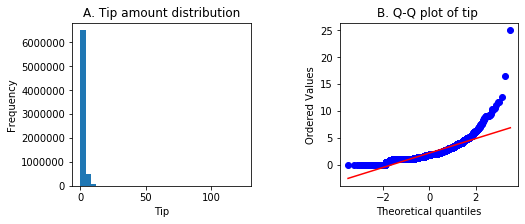

In [81]:
# Plot tip percentage distribution
fig, ax = plt.subplots(1,2,figsize=(8,3))
fig.subplots_adjust(wspace=.5)

ax[0].hist(df_tip['tip_amount'], bins=30)
ax[0].set(xlabel='Tip amount ($)', ylabel='Number of trips');

ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Tip')
ax[0].set_title('A. Tip amount distribution')

stats.probplot(df_tip['tip_amount'].sample(3000), dist="norm", plot=ax[1])
ax[1].set_title('B. Q-Q plot of tip ')

print("Skewness: %f" % df_tip['tip_amount'].skew())
print("Kurtosis: %f" % df_tip['tip_amount'].kurt())
#fig.savefig('fig7.svg', format='svg',bbox_inches='tight')

print('The average tip is',round(df_tip['tip_amount'].mean(),1),', the standard deviation is',round(df_tip['tip_amount'].std(),1))
print('The median tip is',round(df_tip['tip_amount'].median(),1),', the 95% of tip fell between',
      round(df_tip['tip_amount'].quantile(.025),2),'to',round(df_tip['tip_amount'].quantile(.975), 1))

The distribution of the tip percentage is shown above. Overall, the tip percentage do not follow a normal distribution, and is centered around a few typical values

In [7]:
# Import necessary libraries to build model
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse
from statsmodels.formula.api import ols

from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas_mapper

df_tip.to_pickle('nyc_taxi_model_df_tip.pickle')

In [20]:
df_tip = pd.read_pickle('nyc_taxi_model_df_tip.pickle')

In [21]:
to_drop1 = ['store_and_fwd_flag', 'pickup_datetime', 'payment_type', 
           'dropoff_datetime', 'medallion', 'hack_license', 'pickup_latitude', 'dropoff_latitude',
            'pickup_longitude', 'dropoff_longitude', 'pickup_borough','dropoff_borough', 'pickup_airport', 
            'dropoff_airport', 'trip_geodistance', 'trip_time_in_secs', 'total_amount']

In [ ]:
df_tip2 = df_tip[df_tip.columns.difference(to_drop1)].fillna(0)

In [ ]:
df_tip2.columns

In [40]:
# create dummy variables
df_tip_dummies = pd.get_dummies(df_tip2, columns=['pickup_day','passenger_range','pickuphour_range','dropoffhour_range',
                                   'distance_range','time_range','speed_range','dropoffhour_range',
                                   'pickup_origin','dropoff_dest', 'pickup_day_type', 'rate_code', 'vendor_id', 'dropoff_hour']
                     )

In [41]:
# drop last batch of columns
to_drop2 = ['pickup_day_type', 'dropoff_day_type', 'dropoff_day', 'pickup_day', 'trip_distance', 'trip_logdist', 'pickup_day_date','dropoff_day_date']

In [42]:
X.head()

,distance_range,dropoff_day,dropoff_day_date,dropoff_day_type,dropoff_dest,dropoff_hour,dropoffhour_range,fare_amount,mta_tax,passenger_count,...,rate_code,speed_range,surcharge,time_range,tolls_amount,trip_distance,trip_duration_hour,trip_logdist,trip_speed,vendor_id
3727739,Q3,Tuesday,30,Weekday,manhattan,15,14-15,10.5,0.5,1,...,1,Q2,0.0,Q3,0.0,2.14,0.216667,0.760806,9.876923,VTS
9250456,Q2,Monday,15,Weekday,manhattan,13,12-13,7.5,0.5,1,...,1,Q3,0.0,Q2,0.0,1.50,0.129167,0.405465,11.612903,CMT
3626974,Q1,Tuesday,30,Weekday,manhattan,8,8-9,6.0,0.5,1,...,1,Q2,0.0,Q2,0.0,0.85,0.100000,-0.162519,8.500000,VTS
6960832,Q1,Tuesday,9,Weekday,manhattan,9,8-9,6.0,0.5,1,...,1,Q2,0.0,Q2,0.0,0.87,0.100000,-0.139262,8.700000,VTS
5917631,Q1,Thursday,4,Weekday,manhattan,13,12-13,4.5,0.5,1,...,1,Q1,0.0,Q1,0.0,0.20,0.069444,-1.609438,2.880000,CMT


In [43]:
df_tip2 =df_tip_dummies[df_tip_dummies.columns.difference(to_drop2)]

In [44]:
# sample 2m rows to train and test using various algos
df_tip3 = df_tip2.sample(n = 200000)

In [45]:
df_tip3 =  df_tip3[df_tip3['tip_amount'] != 0]

In [46]:
X = df_tip3.drop(['tip_amount'], axis = 1)

In [93]:
X.to_pickle('X variables for tip model.pickle')

In [4]:
X = pd.read_pickle('X variables for tip model.pickle')

In [47]:
y = df_tip3['tip_amount']

In [5]:
y = pd.read_pickle('y variable for tip model.pickle')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

Wall time: 135 ms


# Model Training 

In [49]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

0.6558108054833267
0.6510250398964419


In [50]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [51]:
MAPE(y_test, predictions)

45.665751789374916

In [143]:
y_pred = lm.predict(X_test)
lrmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
lrmse

1.0164475006812137

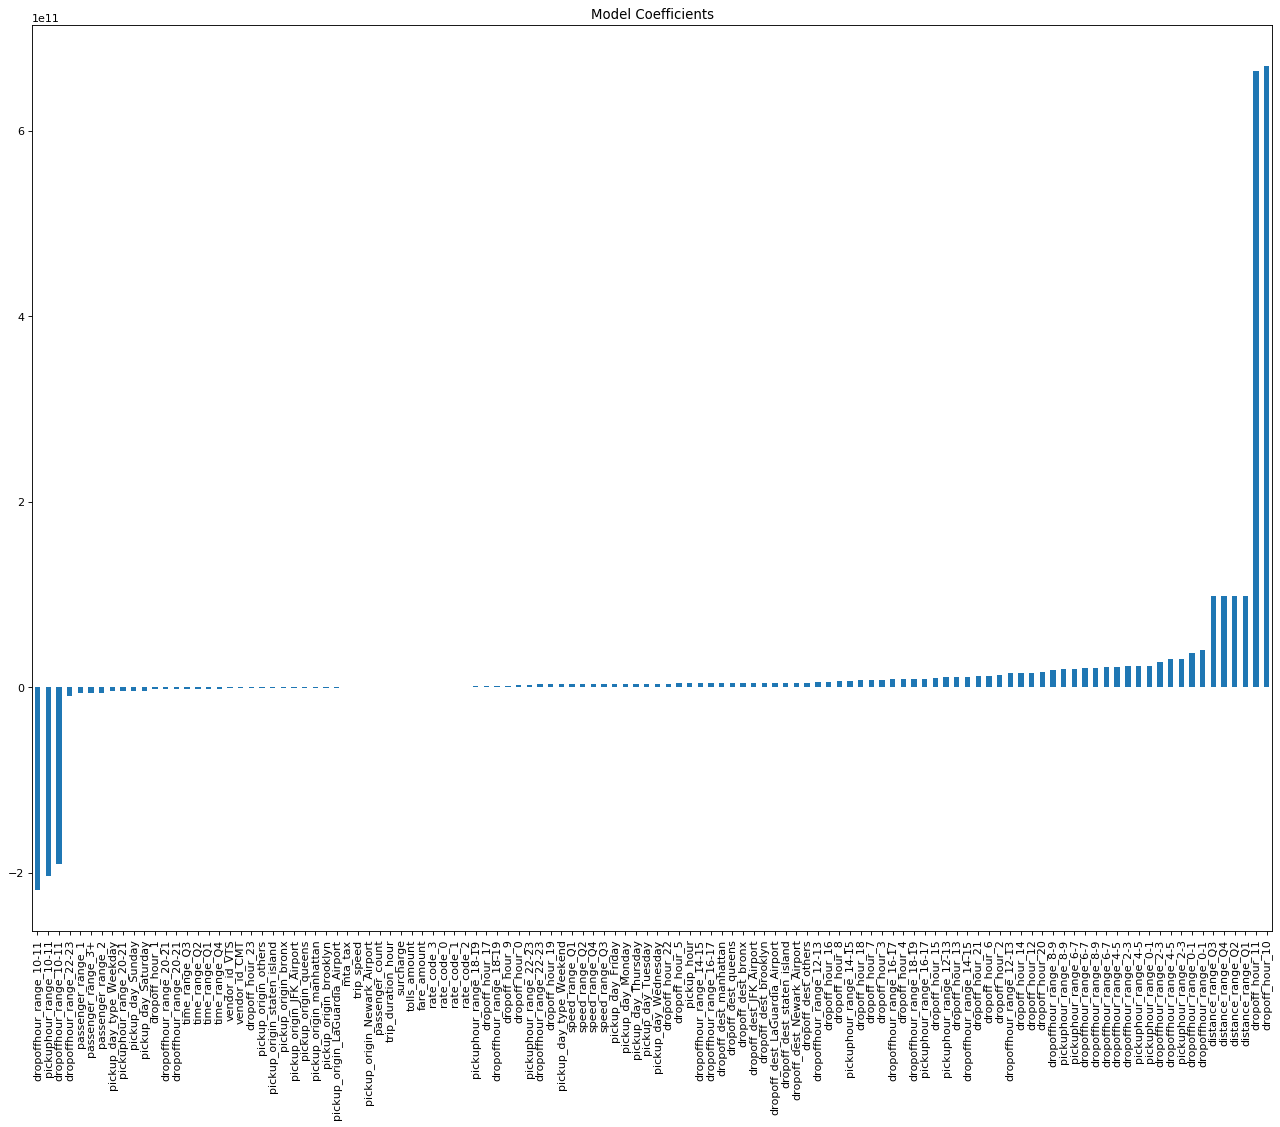

In [126]:
coef1 = pd.Series(lm.coef_, X.columns).sort_values()
from matplotlib.pyplot import figure

figure(figsize=(20, 15), dpi=80)
coef1.plot(kind='bar', title='Model Coefficients')


In [129]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(random_state=42)
randomForest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [130]:
from  sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
import xgboost as xgb

In [131]:
randomForestPredict = randomForest.predict(X_test)
randomForest_mse = mean_squared_error(y_test, randomForestPredict)
randomForestMSE = np.sqrt(randomForest_mse)
randomForestMSE

1.0717162165951715

In [132]:
model = RandomForestRegressor(n_estimators=25, max_features=6, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)

In [133]:
randomForestImproved = model.fit(X_train,y_train)

In [134]:
randomForestImprovedPredict = randomForestImproved.predict(X_test)
randomForestImproved_mse = mean_squared_error(y_test, randomForestImprovedPredict)
randomForestImprovedMSE = np.sqrt(randomForestImproved_mse)
randomForestImprovedMSE

1.0510543014736362

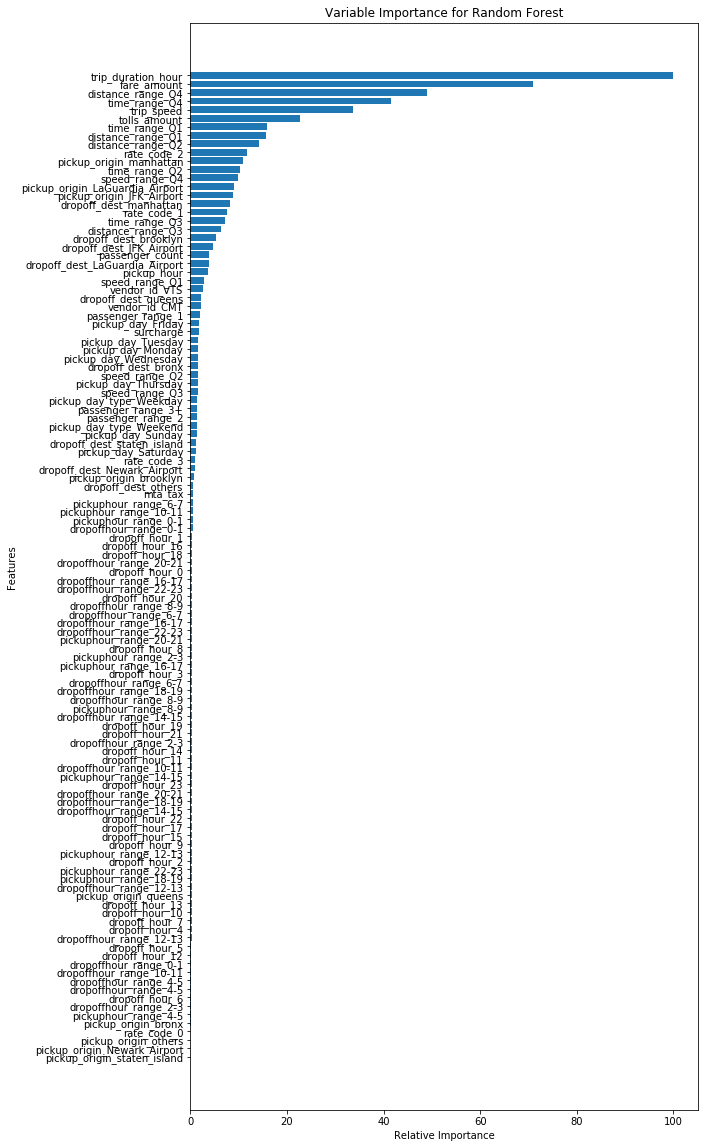

In [135]:
feature_importance = randomForestImproved.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest')
plt.show()

In [136]:
from sklearn.ensemble import GradientBoostingRegressor
model_gradient= GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=3, random_state=0)
gradientBoost = model_gradient.fit(X_train, y_train)

In [137]:
predicted = model_gradient.predict(X_test)

In [138]:
grmse = np.sqrt(metrics.mean_squared_error(predicted, y_test))
grmse

1.1127980131323782

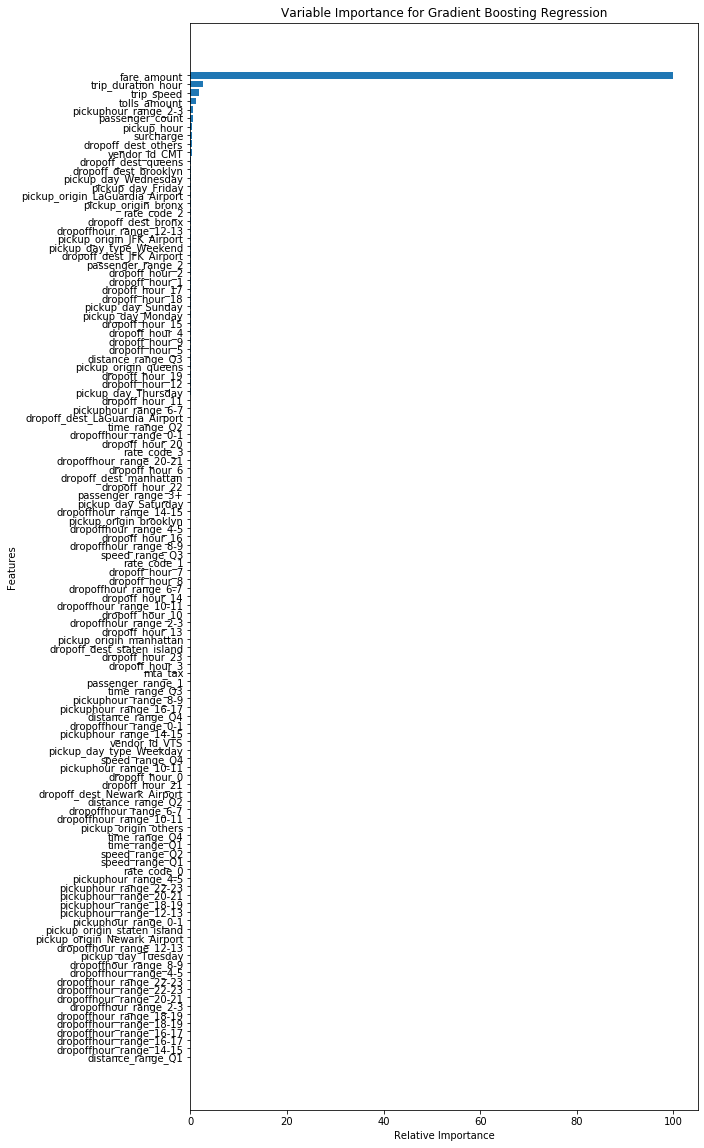

In [139]:
feature_importance = gradientBoost.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Gradient Boosting Regression')
plt.show()

In [144]:
regression = pd.DataFrame({"regression": ['Multi Linear Regression','Random Forest', 'Improved Random Forest', 'Gradient Boosting Regrssion'], "rmse": [lrmse,randomForestMSE,randomForestImprovedMSE,grmse]},columns = ['regression','rmse'])

In [145]:
regression = regression.sort_values(by='rmse', ascending = False)

Text(0.5, 1.0, 'Comparing the different types of Regressions used')

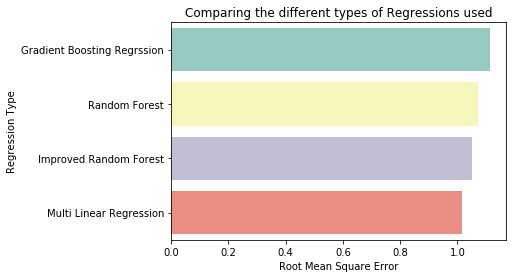

In [146]:
sns.barplot(regression['rmse'], regression['regression'], palette = 'Set3')
plt.xlabel("Root Mean Square Error")
plt.ylabel('Regression Type')
plt.title('Comparing the different types of Regressions used')